<a href="https://colab.research.google.com/github/SantiagoUNAL/ML-Applications-in-Actuarial-Sciences/blob/main/Clasificador_y_generador_de_d%C3%ADgitos_utilizando_naive_bayes_Santiago_Prieto_Berancur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> # Clasificador y generador de dígitos utilizando naive bayes


En esta primera parte importamos todos los paquetes y librerias que vamos a utilizar a lo largo de este trabajo.

In [1]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used


En la siguiente parte cargamos al cuaderno de Colab la base de datos MNIST ubicada en Keras que será utilizada para construir un modelo de clasificación y generación de dígitos. En esta parte, contamos con $60000$ datos de entrenamiento y usaremos $10000$ datos para hacer el test del modelo.

A lo largo de este cuaderno se va a implementar el modelo de Naive Bayes y será entrenado con los $60000$ datos de entrenamiento y evaluaremos como fue su capacidad de generalización en los $10000$ datos de testeo para determinar si el modelo es capaz de clasificar correctamente un dígito dada una imagen que lo representa.

In [2]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


En esta parte se implementa una porción de código que permita gráficar los datos almacenados en la base de datos MNIST. De esta manera, en esta sección es posible visualizar los números representados como matrices $28 \times 28$ que serán usados en el modelo como datos de entrenamiento.

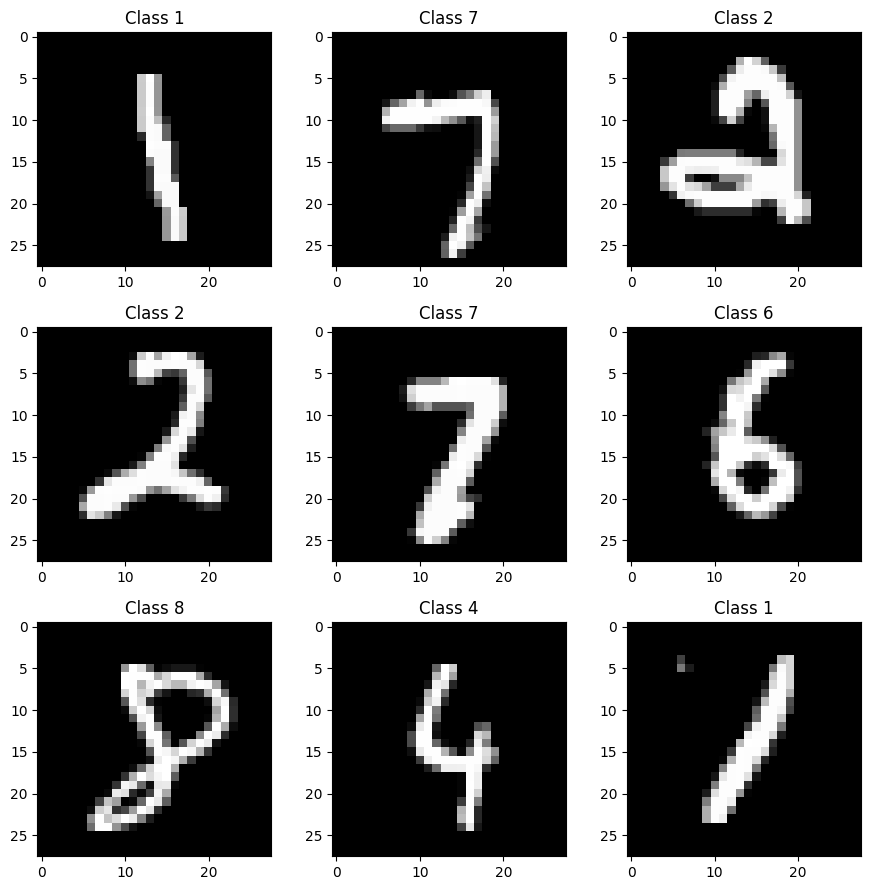

In [3]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))

plt.tight_layout()

El siguiente código nos permite ver de una forma más explicita como estan organizadas las matrices dentro de la base de datos y a su vez nos da un mejor entendimiento de la estructura de las imagenes de estos números en donde cada entrada es un pixel el cual es un entero de 8-bits en el rango de 0-255. 0 es completamente negro, mientras que 255 es completamente blanco. Esto se conoce como pixel de un solo canal. Tambien llamado monocromatico.

In [4]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!
matprint(X_train[num])

0  0  0  0  0  0    0   0  0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0    0   0  0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0    0   0  0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0    0   0  0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0   64   0  0    0    0    0    0    0    0    0    0    0  188  214  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  121  28  0    0    0    0    0    0    0    0    0  121  250  213  0  0  0  0  0  0  0  0  
0  0  0  0  0  0    0   0  0    0    0    0    0    0    0    0    0  201  253  213  0  0  0  0  0  0  0  0  
0  0  0  0  0  0    0   0  0    0    0    0    0    0    0    0   26  217  253  213  0  0  0  0  0  0  0  0  
0  0  0  0  0  0    0   0  0    0    0    0    0    0    0    0   81  253  253  177  0  0  0  0  0  0  0  0  
0  0  0  0

In [5]:
# X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
# X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

# X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
# X_test = X_test.astype('float32')

# X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
# X_test /= 255

# print("Training matrix shape", X_train.shape)
# print("Testing matrix shape", X_test.shape)

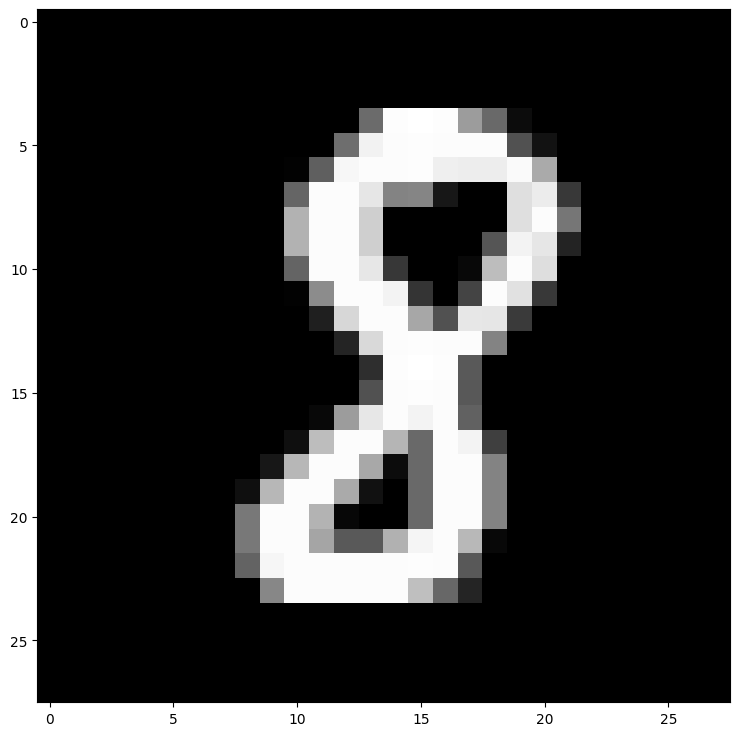

In [6]:
plt.imshow(X_train[24000], cmap='gray', interpolation='none')

# 2. Construcción del modelo Naive Bayes

En esta parte, se implementa un algoritmo que permita almacenar las probabilidades asociadas a cada pixel dado un respectivo dígito entre 0 y 9. Es decir, se almacena en la memoria interna del computador las siguientes probabilidades condicionales
$$P(F_{ij}|k)$$
donde $F_{ij}$ es un pixel dentro de la imagen del dígito con $i,j \in \{1,2,\ldots,28\}$ y $k \in \{0,1,\ldots,9\}$.

In [7]:
a = X_train.shape
digit_vector = []

#Dictionary of square matrices in the variable CumPaidLoss_F2 for all the entities
number_dictionary = {}
probability_dictionary = {}

for i in range(10):
  number_dictionary[i] = []

for i in range(a[0]):
  number_dictionary[y_train[i]].append(X_train[i])

for i in range(10):
  probability_dictionary[i] = np.zeros((28, 28))

for i in range(10):
  n = len(number_dictionary[i])
  counter = 0
  for k in range(28):
    for h in range(28):
      for j in range(n):
        if number_dictionary[i][j][k,h] > 100:
          counter = counter + 1

      probability_dictionary[i][k,h] = counter / n

      counter = 0



En esta parte, se calculan las probabilidades de obtener un determinado dígito dado un número selecto de pixeles encendidos. Es decir, se calcula
$$P(k|F_{1},F_{2},\ldots,F_{n}) ∝ P(k)∏_{i=1}^{n}P(F_{i}|k)$$
donde $k \in \{0,1,\ldots,9\}$.

Una vez calculadas las probabilidades se almacenan en un diccionario en donde cada dato de test tiene asociado un vector en $\mathbb{R}^{10}$ que contiene las probabilidades de que esa imagen provenga de un determinado dígito. Posteriormente el algoritmo nos ayudará a decidir que dígito corresponde a cada uno de los datos de test al analizar cual de las probabilidades calculadas previamente es máxima.

In [8]:
probability_vector = []
probability_vector_dictionary = {}

b = X_test.shape

for i in range(b[0]):
  probability_vector_dictionary[i] = []
  for j in range(10):
    n = len(number_dictionary[j])
    P_number = n / 60000
    P_final = 1
    for k in range(28):
      for h in range(28):
        if X_test[i][k,h] > 100:
          P_final = P_final * probability_dictionary[j][k,h]

    P_final = P_final * P_number
    probability_vector_dictionary[i].append(P_final)

  # print(i)




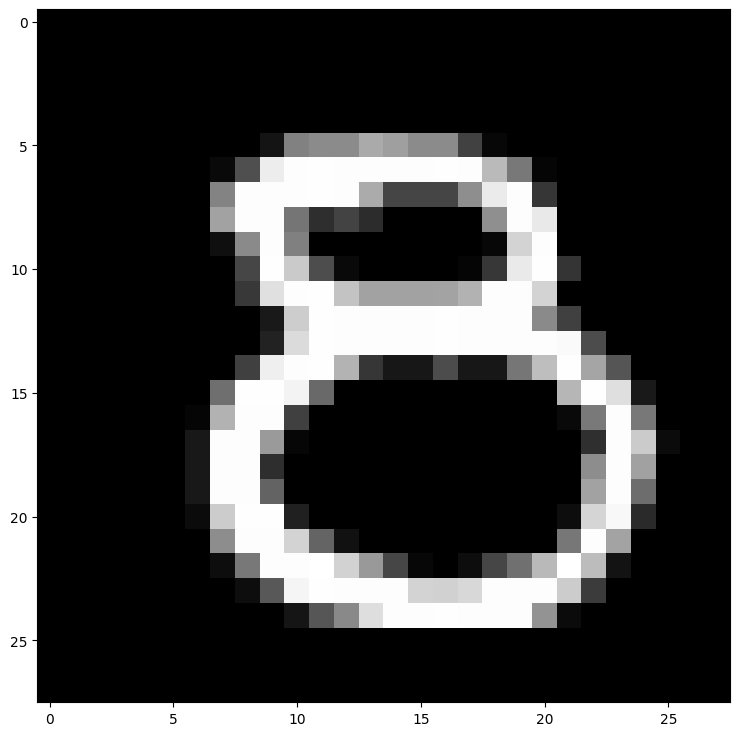

In [9]:
plt.imshow(X_test[338], cmap='gray', interpolation='none')

In [10]:
y_test[337]

7

# 3. Reporte de desempeño del modelo

En esta sección se mide el desempeño del modelo implementado utilizando como medidas de desempeño la precisión y el recall.

In [11]:
from sklearn.metrics import classification_report

b = X_test.shape
model_results = []

for i in range(b[0]):
  max_index = probability_vector_dictionary[i].index(max(probability_vector_dictionary[i]))
  model_results.append(max_index)

target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']
print(classification_report(y_test, model_results, target_names=target_names))




              precision    recall  f1-score   support

     class 0       0.72      0.97      0.83       980
     class 1       1.00      0.34      0.51      1135
     class 2       0.84      0.83      0.83      1032
     class 3       0.80      0.80      0.80      1010
     class 4       0.92      0.55      0.69       982
     class 5       0.97      0.25      0.39       892
     class 6       0.90      0.86      0.88       958
     class 7       0.99      0.67      0.80      1028
     class 8       0.32      0.92      0.47       974
     class 9       0.74      0.74      0.74      1009

    accuracy                           0.69     10000
   macro avg       0.82      0.69      0.69     10000
weighted avg       0.82      0.69      0.70     10000



In [12]:
model_results[338]

0

En general es posible evidenciar que el desempeño del modelo en los datos de test está por encima del $70 \%$ para la mayoria de las clases y ademas se tiene un desempeño general del $82 \%$ de precisión en todos los datos de test. Este hecho brinda un buen indicativo de que el modelo generaliza en un gran número de casos.

# 4. Construcción de un modelo que permite sintetizar un nuevo dígito

A continuación se implementa un código en donde dado un dígito entre 0 a 9 se sintetiza una imagen que representa dicho número.

Please enter a natural number between 0 and 9: 
5
Your number is: 5
5


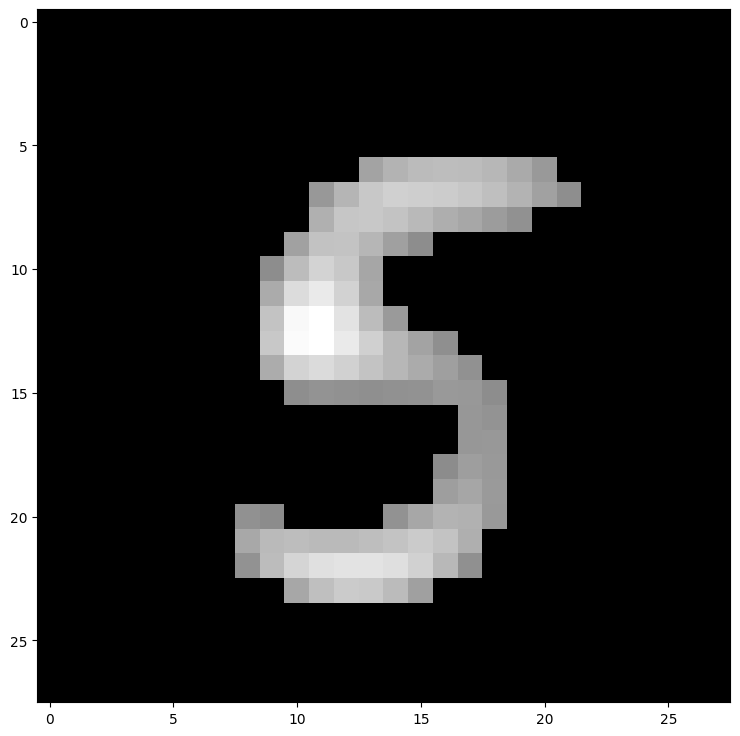

In [14]:
number_input = input("Please enter a natural number between 0 and 9: \n")
print("Your number is: " + number_input)
print(number_input)

number_input = int(number_input)


A = np.zeros((28, 28))
for i in range(28):
  for j in range(28):
    if probability_dictionary[number_input][i,j]>= 0.4:
      # A[i,j] = 100
      A[i,j] = 255 * probability_dictionary[number_input][i,j]

plt.imshow(A, cmap='gray', interpolation='none')